# Flood Model Training Notebook

Train a Flood ConvLSTM Model using `usl_models` lib.

In [ ]:
import tensorflow as tf
import keras_tuner
import time
import keras
import logging
from usl_models.flood_ml import constants
from usl_models.flood_ml.model import FloodModel
from usl_models.flood_ml.model_params import FloodModelParams
from usl_models.flood_ml.dataset import load_dataset_windowed, load_dataset
from usl_models.flood_ml import customloss

# Setup
logging.getLogger().setLevel(logging.WARNING)
keras.utils.set_random_seed(812)

for gpu in tf.config.list_physical_devices("GPU"):
    tf.config.experimental.set_memory_growth(gpu, True)

timestamp = time.strftime("%Y%m%d-%H%M%S")

# Cities and their config folders
city_config_mapping = {
    #"Manhattan": "Manhattan_config",
    "Atlanta": "Atlanta_config",
    #"Phoenix_SM": "PHX_SM",
    #"Phoenix_PV": "PHX_PV",
}

# Rainfall files you want
rainfall_files = [5]  # Only 5 and 6

# Generate sim_names
sim_names = []
for city, config in city_config_mapping.items():
    for rain_id in rainfall_files:
        sim_name = f"{city}-{config}/Rainfall_Data_{rain_id}.txt"
        sim_names.append(sim_name)

print(f"Training on {len(sim_names)} simulations.")
for s in sim_names:
    print(s)

# Now load dataset
train_dataset = load_dataset_windowed(
    sim_names=sim_names, batch_size=4, dataset_split="train"
).cache()

validation_dataset = load_dataset_windowed(
    sim_names=sim_names,
    batch_size=4,
    dataset_split='val'
).cache()

# Now you can pass these into your model training like usual
print(sim_names)

In [ ]:
tuner = keras_tuner.BayesianOptimization(
    FloodModel.get_hypermodel(
        lstm_units=[32, 64, 128],
        lstm_kernel_size=[3, 5],
        lstm_dropout=[0.2, 0.3],
        lstm_recurrent_dropout=[0.2, 0.3],
        n_flood_maps=[5],
        m_rainfall=[6],
    ),
    objective="val_loss",
    max_trials=1,
    project_name=f"logs/htune_project_{timestamp}",
)

tuner.search_space_summary()

In [ ]:
log_dir = f"logs/htune_project_{timestamp}"
print(log_dir)
tb_callback = keras.callbacks.TensorBoard(log_dir=log_dir)
tuner.search(
    train_dataset,
    epochs=2,
    validation_data=validation_dataset,
    callbacks=[tb_callback],
)
best_model, best_hp = tuner.get_best_models()[0], tuner.get_best_hyperparameters()[0]
best_hp.values

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Define final parameters and model
final_params = FloodModel.Params(**best_hp.values)
model = FloodModel(params=final_params)

# Define callbacks
callbacks = [
    keras.callbacks.TensorBoard(log_dir=log_dir),
    ModelCheckpoint(
        filepath=log_dir + "/checkpoint",
        save_best_only=True,
        monitor="val_loss",
        mode="min",
        save_format="tf"
    ),
    EarlyStopping(               # <--- ADD THIS
        monitor="val_loss",       # What to monitor
        patience=10,              # Number of epochs with no improvement to wait
        restore_best_weights=True, # Restore model weights from best epoch
        mode="min"                # "min" because lower val_loss is better
    )
]

# Train
model.fit(
    train_dataset,
    validation_dataset,
    epochs=200,
    callbacks=callbacks
)

# Save final model
model.save_model(log_dir + "/model")


In [ ]:
# # Test calling the model on some data.
inputs, labels_ = next(iter(train_dataset))
prediction = model.call(inputs)
prediction.shape

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from usl_models.flood_ml.dataset import load_dataset_windowed
from usl_models.flood_ml import constants

# Path to trained model
model_path = "/home/jainr/climateiq-cnn-5/logs/htune_project_20250430-182544/model"
model = tf.keras.models.load_model(model_path)

# Number of samples to visualize
n_samples = 20

# Loop through the dataset and predict
for i, (input_data, ground_truth) in enumerate(validation_dataset.take(n_samples)):
    ground_truth = ground_truth.numpy().squeeze()
    prediction = model(input_data).numpy().squeeze()

    print(f"\nSample {i+1} Prediction Stats:")
    print("  Min:", prediction.min())
    print("  Max:", prediction.max())
    print("  Mean:", prediction.mean())

    # Choose timestep to plot
    timestep = 3
    gt_t = ground_truth[timestep]
    pred_t = prediction[timestep]
    vmax_val = max(gt_t.max(), pred_t.max())

    # Plot Ground Truth and Prediction
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle(f"Sample {i+1} - Timestep {timestep}", fontsize=16)

    im1 = axes[0].imshow(gt_t, cmap="Blues", vmin=0, vmax=vmax_val)
    axes[0].set_title("Ground Truth")
    axes[0].axis("off")
    plt.colorbar(im1, ax=axes[0], shrink=0.8)

    im2 = axes[1].imshow(pred_t, cmap="Blues", vmin=0, vmax=vmax_val)
    axes[1].set_title("Prediction")
    axes[1].axis("off")
    plt.colorbar(im2, ax=axes[1], shrink=0.8)

    plt.tight_layout()
    plt.show()


In [1]:
from google.cloud import firestore, storage

firestore_client = firestore.Client(project="climateiq-test")
storage_client = storage.Client(project="climateiq-test")


In [2]:
import os
os.environ["GOOGLE_CLOUD_PROJECT"] = "climateiq-test" #(forces the project into climateiq-test)

In [3]:
from google.cloud import storage
print(storage.Client().project) #this prints climateiq-test 

climateiq-test


In [4]:
import pathlib
import time
import numpy as np
import tensorflow as tf
import keras
import keras_tuner

# FloodML modules (your repo)
from usl_models.flood_ml.dataset import download_dataset, load_dataset_windowed_cached, load_prediction_dataset_cached
from usl_models.flood_ml.model import FloodModel
from usl_models.flood_ml import constants
import logging
import random
from google.cloud import firestore
from google.cloud import storage


2025-09-02 14:16:48.361188: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-02 14:16:49.108554: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-09-02 14:16:49.108647: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-09-02 14:16:49.241819: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-09-02 14:16:49.493392: I tensorflow/core/platform/cpu_feature_guar

In [5]:
import pathlib
from usl_models.flood_ml.dataset import download_dataset, load_dataset_cached_auto, load_prediction_dataset, load_prediction_dataset_cached


filecache_dir = pathlib.Path("/home/shared/climateq/filecache")

city_config_mapping = {
    #"Manhattan": "Manhattan_config",
    "Atlanta_Prediction": "Atlanta_config",  # study area contains "Prediction"
}

# same-level approach with rainfall_files list
rainfall_files = [4]  # rainfall scenario number

sim_names = []
for city, config in city_config_mapping.items():
    for rain_id in rainfall_files:
        sim_name = f"{city}-{config}/Rainfall_Data_{rain_id}.txt"
        sim_names.append(sim_name)

dataset_splits = ["train", "val"]

download_dataset(
    sim_names=sim_names,
    output_path=filecache_dir,
    dataset_splits=dataset_splits,   # creates train/ and val/
)


  ✓ [Prediction] Saved temporal.npy and 56 normalized feature chunks to each of splits ['train', 'val'] for Atlanta_Prediction-Atlanta_config/Rainfall_Data_4.txt (no labels).


In [6]:
from pathlib import Path

filecache_dir = Path("/home/shared/climateq/filecache")
sim_pred = ["Atlanta_Prediction-Atlanta_config/Rainfall_Data_4.txt"]

pred_ds = load_prediction_dataset_cached(
    filecache_dir=filecache_dir,
    sim_names=sim_pred,
    dataset_split="train",   # works for train/val/test/predict
    batch_size=1,
)

for inputs, meta in pred_ds.take(1):
    print("[PRED] geospatial:", inputs["geospatial"].shape)      # (1,H,W,G)
    print("[PRED] temporal  :", inputs["temporal"].shape)        # (1,n_flood_maps,m_rainfall)
    print("[PRED] spatiotemp:", inputs["spatiotemporal"].shape)  # (1,n_flood_maps,H,W,1)
    print("[PRED] meta keys :", list(meta.keys()))


2025-09-02 14:18:29.504991: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38364 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:00:04.0, compute capability: 8.0


[PRED] geospatial: (1, 1000, 1000, 9)
[PRED] temporal  : (1, 5, 6)
[PRED] spatiotemp: (1, 5, 1000, 1000, 1)
[PRED] meta keys : ['feature_chunk', 'rainfall']


In [ ]:
from usl_models.flood_ml.dataset import load_dataset_cached
sim_real = ["Manhattan-Manhattan_config/Rainfall_Data_4.txt"]  # adjust if needed

real_ds = load_dataset_cached(
    filecache_dir=filecache_dir,
    sim_names=sim_real,
    dataset_split="train",   
    batch_size=1,
)

for inputs, labels in real_ds.take(1):
    print("[REAL] geospatial:", inputs["geospatial"].shape)      # (1,H,W,G)
    print("[REAL] temporal  :", inputs["temporal"].shape)        # (1,n_flood_maps,m_rainfall)
    print("[REAL] spatiotemp:", inputs["spatiotemporal"].shape)  # (1,n_flood_maps,H,W,1)
    print("[REAL] labels    :", labels.shape)                    # (1,H,W)
   


[REAL] geospatial: (1, 1000, 1000, 9)
[REAL] temporal  : (1, 5, 6)
[REAL] spatiotemp: (1, 5, 1000, 1000, 1)
[REAL] labels    : (1, 1000, 1000)


In [8]:
# one batch
inputs, labels = next(iter(real_ds.take(1)))
print("label stats:",
      float(tf.reduce_min(labels).numpy()),
      float(tf.reduce_max(labels).numpy()),
      int(tf.math.count_nonzero(labels).numpy()))


label stats: 0.0 3.632999897003174 239993


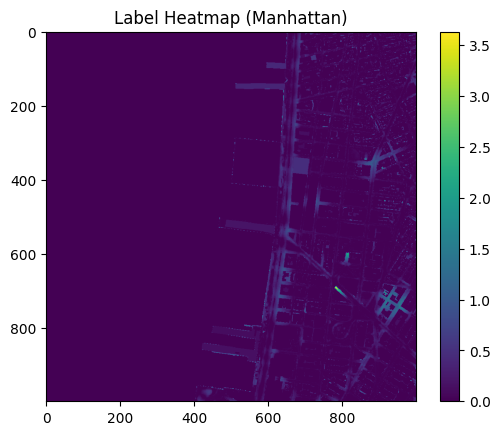

In [11]:
import matplotlib.pyplot as plt

plt.imshow(lab, cmap="viridis")
plt.colorbar()
plt.title("Label Heatmap (Manhattan)")
plt.show()


In [12]:
import numpy as np
from pathlib import Path

lab_path = Path("/home/shared/climateq/filecache/Manhattan-Manhattan_config/Rainfall_Data_4.txt/train/labels/1_8.npy")
raw = np.load(str(lab_path))  # will print (1000,1000,13) then labels are loaded
print("raw shape:", raw.shape)
print("per-channel max:", raw.max(axis=(0,1)))  # one max per channel


raw shape: (1000, 1000, 13)
per-channel max: [0.    0.32  0.653 2.866 3.377 3.633 3.628 3.623 3.624 3.622 3.622 3.622
 3.619]
